c:\Users\46021\.conda\envs\lffl\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


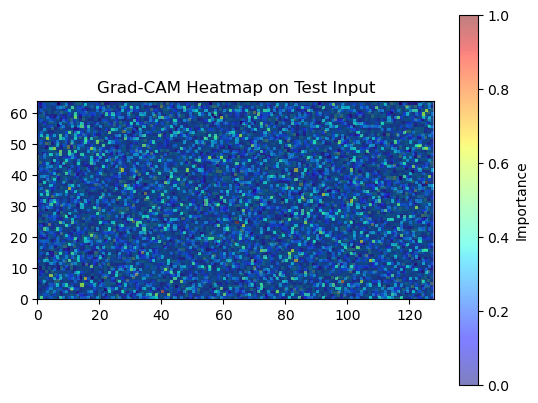

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define a simple CNN model
class TestCNN(nn.Module):
    def __init__(self):
        super(TestCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, 2)  # Assume 2 output classes

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create a test input tensor
def generate_test_data():
    batch_size = 1
    channels = 1
    height = 64  # Example Mel spectrogram height
    width = 128  # Example Mel spectrogram width
    return torch.randn(batch_size, channels, height, width)

# Test case
if __name__ == "__main__":
    # Instantiate the model and input
    model = TestCNN()
    input_tensor = generate_test_data()

    # Select the target layer and target class
    target_layer = model.conv2  # Second convolutional layer
    target_class = 1  # Example class index (0 or 1 for this toy model)

    # Grad-CAM function
    def grad_cam(model, input_tensor, target_layer, target_class):
        model.eval()  # Set the model to evaluation mode
        
        gradients = []
        activations = []

        def backward_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0])

        def forward_hook(module, input, output):
            activations.append(output)

        hook_b = target_layer.register_backward_hook(backward_hook)
        hook_f = target_layer.register_forward_hook(forward_hook)

        output = model(input_tensor)
        class_score = output[0, target_class]

        model.zero_grad()
        class_score.backward()

        grad = gradients[0].cpu().data.numpy()[0]
        act = activations[0].cpu().data.numpy()[0]

        hook_b.remove()
        hook_f.remove()

        weights = np.mean(grad, axis=(1, 2))
        cam = np.sum(weights[:, None, None] * act, axis=0)

        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam) if np.max(cam) != 0 else cam

        return cam

    # Generate Grad-CAM heatmap
    cam = grad_cam(model, input_tensor, target_layer, target_class)

    # Plot the heatmap on the test Mel spectrogram
    plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='viridis')
    plt.imshow(cam, cmap='jet', alpha=0.5, extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2)))
    plt.colorbar(label='Importance')
    plt.title('Grad-CAM Heatmap on Test Input')
    plt.show()


In [176]:
import torch
import torch.nn as nn

In [177]:
class TestCNN(nn.Module):
    def __init__(self):
        super(TestCNN, self).__init__()
        self.convs = [
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=(1, 2)), 
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2), 
            nn.Conv2d(64, 256, kernel_size=7, stride=1, padding=3)
        ]
        self.bns = [nn.BatchNorm2d(16), nn.BatchNorm2d(64), nn.BatchNorm2d(256)]
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4, return_indices=True)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    def forward(self, x):
        wheres = []
        for leap in range(3):
            x = self.act(self.bns[leap](self.convs[leap](x)))
            print(f"leap:{leap}", x.shape)
            x, where = self.pool(x)
            print(f"leap after pool:{leap}", x.shape)
            wheres.append(where)
        x = self.avgpool(x)
        return x, wheres

In [178]:
x = torch.randn(2, 1, 128, 126)

y, wheres = TestCNN()(x)

leap:0 torch.Size([2, 16, 128, 128])
leap after pool:0 torch.Size([2, 16, 32, 32])
leap:1 torch.Size([2, 64, 32, 32])
leap after pool:1 torch.Size([2, 64, 8, 8])
leap:2 torch.Size([2, 256, 8, 8])
leap after pool:2 torch.Size([2, 256, 2, 2])


In [179]:
for where in wheres:
    print(where.shape)

torch.Size([2, 16, 32, 32])
torch.Size([2, 64, 8, 8])
torch.Size([2, 256, 2, 2])


In [180]:
y.shape

torch.Size([2, 256, 1, 1])

In [ ]:
# , output_padding=(0, 1)

In [203]:
class TestCNNDec(nn.Module):
    def __init__(self):
        super(TestCNNDec, self).__init__()
        self.last_pool = nn.ConvTranspose2d(256,256, kernel_size=2, stride=2) # 1, 1 -> 3, 3
        self.convs = [
            nn.ConvTranspose2d(256, 64, kernel_size=7, stride=1, padding=3),
            nn.ConvTranspose2d(64, 16, kernel_size=5, stride=1, padding=2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=(1, 2))
        ]
        self.bns = [nn.BatchNorm2d(64), nn.BatchNorm2d(16), nn.BatchNorm2d(1)]
        self.act = nn.ReLU()
        self.pool = nn.MaxUnpool2d(kernel_size=4, stride=4)
    def forward(self, x, wheres):
        wheres = wheres[::-1]
        x = self.last_pool(x)
        for leap in range(3): 
            x = self.pool(x, wheres[leap])
            x = self.act(self.bns[leap](self.convs[leap](x)))
        return x

In [204]:
wheres[0].shape

torch.Size([2, 16, 32, 32])

In [190]:
x1 = nn.MaxUnpool2d(kernel_size=4, stride=4)(torch.randn(2, 256, 2, 2), wheres[2])

In [192]:
x2 = nn.ConvTranspose2d(256, 64, kernel_size=7, stride=1, padding=3)(x1)

In [196]:
x3 = nn.MaxUnpool2d(kernel_size=4, stride=4)(x2, wheres[1])

In [197]:
x4 = nn.ConvTranspose2d(64, 16, kernel_size=5, stride=1, padding=2)(x3)

In [199]:
x5 = nn.MaxUnpool2d(kernel_size=4, stride=4)(x4, wheres[0])

In [201]:
x6 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=(1, 2))(x5)

In [205]:
decoder = TestCNNDec()

In [206]:
decoder(z, wheres).shape

torch.Size([2, 1, 128, 126])

In [49]:
nn.ConvTranspose2d(256,256, kernel_size=3, stride=3)(z).shape

torch.Size([2, 256, 3, 3])

In [207]:
from torchinfo import summary

In [213]:
model = TestCNN().to("cpu")

In [2]:
import torch

In [3]:
x = torch.randn(2, 256, 1, 1)

In [4]:
torch.flatten(x, start_dim=1).shape

torch.Size([2, 256])

In [ ]:
model(torch.randn(2, 1, 128, 126))

leap:0 torch.Size([2, 16, 128, 128])
leap after pool:0 torch.Size([2, 16, 32, 32])
leap:1 torch.Size([2, 64, 32, 32])
leap after pool:1 torch.Size([2, 64, 8, 8])
leap:2 torch.Size([2, 256, 8, 8])
leap after pool:2 torch.Size([2, 256, 2, 2])


(tensor([[[[1.6662]],
 
          [[1.4342]],
 
          [[1.9362]],
 
          [[1.4821]],
 
          [[1.5295]],
 
          [[1.7372]],
 
          [[1.4443]],
 
          [[1.2617]],
 
          [[1.4929]],
 
          [[1.9195]],
 
          [[1.3084]],
 
          [[1.5539]],
 
          [[1.2781]],
 
          [[1.1479]],
 
          [[1.5439]],
 
          [[1.7509]],
 
          [[1.5466]],
 
          [[1.6082]],
 
          [[1.7275]],
 
          [[1.6041]],
 
          [[1.8514]],
 
          [[1.3907]],
 
          [[1.3543]],
 
          [[1.3022]],
 
          [[1.4680]],
 
          [[1.4815]],
 
          [[1.7728]],
 
          [[1.6872]],
 
          [[1.2004]],
 
          [[1.2356]],
 
          [[1.9393]],
 
          [[2.1248]],
 
          [[1.4744]],
 
          [[1.8118]],
 
          [[1.8453]],
 
          [[2.0733]],
 
          [[1.5128]],
 
          [[1.2762]],
 
          [[1.9824]],
 
          [[1.1478]],
 
          [[1.3822]],
 
          [[1.39

: 

In [214]:
summary(model, input_size=(128, 1, 128, 126))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [46]:
hidrep = torch.randn(300, 256)
y = torch.randint(0, 4, (300,))

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Assume hidrep is of shape (number, 256), and y contains labels (0, 1, 2, 3).
# hidrep = your_encoder_output
# y = your_labels

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(hidrep, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Initialize Logistic Regression with appropriate parameters.
clf = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')

# Train the classifier.
clf.fit(X_train, y_train)

# Make predictions.
y_pred = clf.predict(X_test)

# Evaluate the model.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.16666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.07      0.06        15
           1       0.14      0.18      0.16        11
           2       0.29      0.24      0.26        17
           3       0.25      0.18      0.21        17

    accuracy                           0.17        60
   macro avg       0.18      0.17      0.17        60
weighted avg       0.19      0.17      0.18        60



In [ ]:
str(classification_report(y_test, y_pred))

'              precision    recall  f1-score   support\n\n           0       0.05      0.07      0.06        15\n           1       0.14      0.18      0.16        11\n           2       0.29      0.24      0.26        17\n           3       0.25      0.18      0.21        17\n\n    accuracy                           0.17        60\n   macro avg       0.18      0.17      0.17        60\nweighted avg       0.19      0.17      0.18        60\n'

: 